<h1>Building a movie content based recommender using tf-idf</h1>

### Types of recommender systems

Most recommender systems make use of either or both collaborative filtering and content based filtering. Though current recommender systems typically combine several approaches into a hybrid system. 

Below is a general overview of these methods:

* **Collaborative filtering**: The main idea behind these methods is to use other users’ preferences and taste to recommend new items to a user. The usual procedure is to find similar users (or items) to recommend new items which where liked by those users, and which presumably will also be liked by the user being recommended.

* **Content-Based**: Content based recommenders will instead use data exclusively about the items. For this we need to have a minimal understanding of the users’ preferences, so that we can then recommend new items with similar tags/keywords to those specified (or inferred) by the user.

* **Hybrid methods**: Which, as the name suggests, include techniques combining collaborative filtering, content based and other possible approaches. Nowadays most recommender systems are hybrid, as is the case of factorization machines.

## The MovieLens Dataset

One of the most used datasets to test recommender systems is the **MovieLents** dataset, which contains rating data sets from the MovieLens web site. For this blog entry I'll be using a dataset containing 1M anonymous ratings of approximately 4000 movies made by 6000 MovieLens users,  released in 2/2003.

Let's get a glimpse of the data contained in this dataset. We have three .csv files: ratings, users, and movies. The filed will be loaded as pandas dataframes. We have a ratings file which looks like:

### Data Preparation
Let's load this data into Python. I will load the dataset with Pandas onto Dataframes **ratings**, **users**, and **movies**. Before that, I'll also pass in column names for each CSV and read them using pandas.

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
import seaborn as sns

ratings = pd.read_csv('data\Content_based_recommenders/ratings.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'movie_id', 'rating'])
users = pd.read_csv('data/Content_based_recommenders/users.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])
movies = pd.read_csv('data/Content_based_recommenders/movies.csv', sep='\t', encoding='latin-1', usecols=['movie_id', 'title', 'genres'])

We have a ratings file which looks like:

In [83]:
ratings.shape

(1000209, 3)

In [84]:
ratings.sample(5)

,user_id,movie_id,rating
668954,4022,2606,2
296476,1758,1193,5
200445,1230,66,1
815160,4893,329,5
844025,5074,3543,4


A movies dataset:

In [85]:
movies.sample(5)

,movie_id,title,genres
1142,1158,Here Comes Cookie (1935),Comedy
978,990,Maximum Risk (1996),Action|Adventure|Thriller
955,967,"Outlaw, The (1943)",Western
441,445,Fatal Instinct (1993),Comedy
1068,1084,Bonnie and Clyde (1967),Crime|Drama


In [112]:
movies.shape

(3883, 3)

Having both a `movie_id` , `title` and a string with all genres separated bythe character `|` 

And the users dataset, with basic information about the user:

In [86]:
users.head()

,user_id,gender,zipcode,age_desc,occ_desc
0,1,F,48067,Under 18,K-12 student
1,2,M,70072,56+,self-employed
2,3,M,55117,25-34,scientist
3,4,M,02460,45-49,executive/managerial
4,5,M,55455,25-34,writer


### Data Exploration

As we'll explore in the next section, the genres alone can be used to provide a reasonably good content based recommendation. But before that, we need analyse some important aspects.

### Ratings
Next I want to examine the **rating** further. One important aspect to consider is the distribution of the user ratings:

<Axes: xlabel='rating', ylabel='count'>

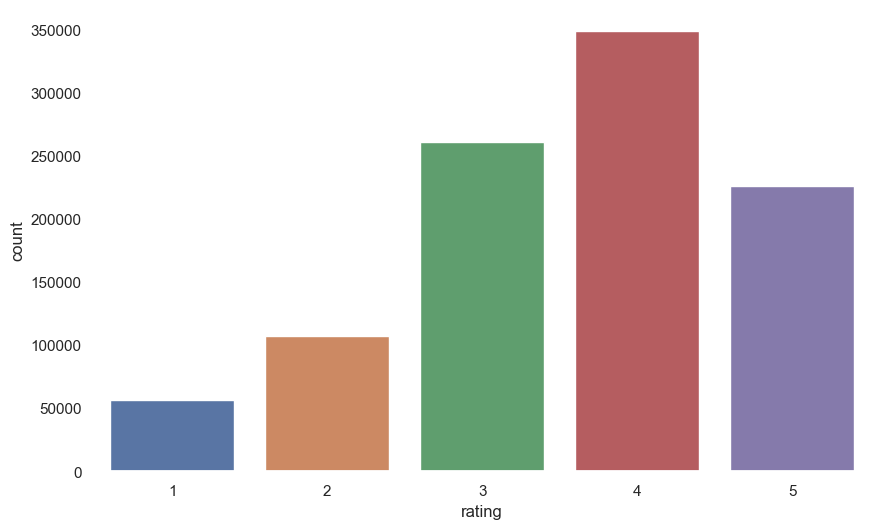

In [87]:
plt.figure(figsize=(10,6))
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
#hi
sns.countplot(data=ratings, x=ratings['rating'].fillna(ratings['rating'].median()))

* *Which are the most popular movies?*

We can take a weighted score taking into account both the **ratings** and the amount of **views** to answer this question:

In [88]:
def weighted_average_score(df, k=0.8):
    n_views = df.groupby('movie_id', sort=False).movie_id.count()
    ratings = df.groupby('movie_id', sort=False).rating.mean()
    scores = ((1-k)*(n_views/n_views.max()) + 
              k*(ratings/ratings.max())).to_numpy().argsort()[::-1]
    df_deduped = df.groupby('movie_id', sort=False).agg({'title':'first',
                                                         'genres':'first',
                                                         'rating':'mean'})
    return df_deduped.assign(views=n_views).iloc[scores]

In [89]:
df = movies.merge(ratings).merge(users)
weighted_average_score(df).head(10)

,title,genres,rating,views
movie_id,,,,
2858,American Beauty (1999),Comedy|Drama,4.317386,3428
260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,4.453694,2991
1198,Raiders of the Lost Ark (1981),Action|Adventure,4.477725,2514
1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,4.292977,2990
318,"Shawshank Redemption, The (1994)",Drama,4.554558,2227
527,Schindler's List (1993),Drama|War,4.510417,2304
858,"Godfather, The (1972)",Action|Crime|Drama,4.524966,2223
2028,Saving Private Ryan (1998),Action|Drama|War,4.337354,2653
2762,"Sixth Sense, The (1999)",Thriller,4.406263,2459


#### Genres

As we'll explore in the next section, the genres alone can be used to provide a reasonably good content based recommendation. But before that, we need analyse some important aspects.

* *Which are the most popular genres?*

This will be a relevant aspect to take into account when building the content based recommender. We want to understand which genres really are relevant when it comes to defining a user's taste. A reasonable assumption is that it is precisely the unpopular genres, that will be more relevant in characterising the user's taste.

The most relevant genres are:

In [90]:
genre_popularity = (movies.genres.str.split('|')
                      .explode()
                      .value_counts()
                      .sort_values(ascending=False))
genre_popularity.head(10)

Drama         1603
Comedy        1200
Action         503
Thriller       492
Romance        471
Horror         343
Adventure      283
Sci-Fi         276
Children's     251
Crime          211
Name: genres, dtype: int64

Or for a more visual representation we could plot a word-cloud with the genres:

(-0.5, 999.5, 399.5, -0.5)

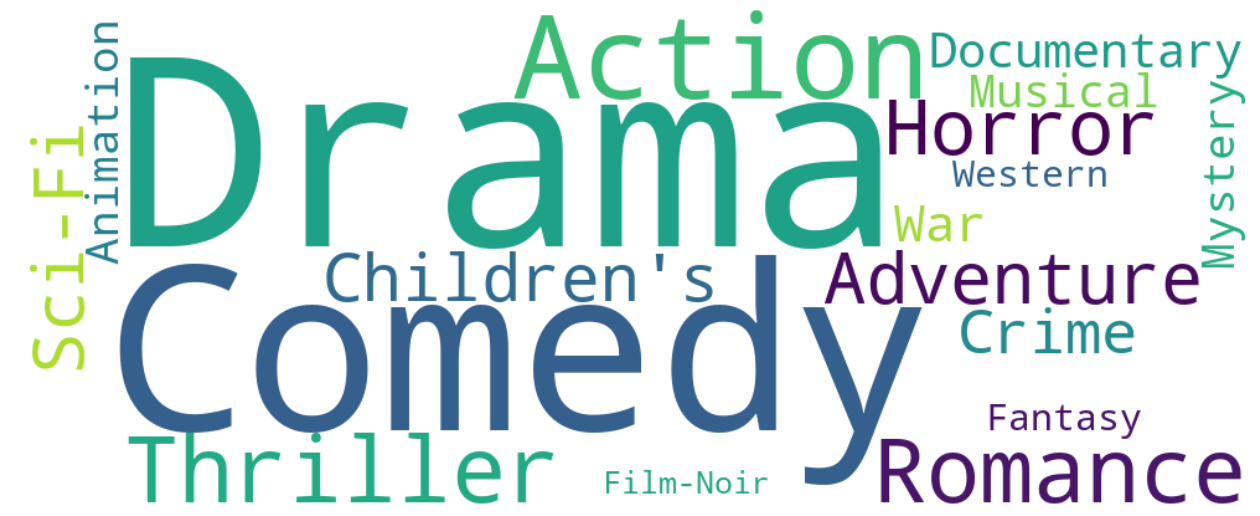

In [91]:
from wordcloud import WordCloud

genre_wc = WordCloud(width=1000,height=400, background_color='white')
genre_wc.generate_from_frequencies(genre_popularity.to_dict())

plt.figure(figsize=(16, 8))
plt.imshow(genre_wc, interpolation="bilinear")
plt.axis('off')

As we can see, the most frequent genres are Drama, Comedy and Action, among others. We then have some other genres that are way less frequent such as Western, Fantasy or Sci-Fi. 

As I previously pointed out, these are the genres that we want to give the most importance to when recommending. Why is that?
As an example let's consider new user wants to find movies similar to Interstellar., which is a mixture of Sci-Fi, Drama, Mistery and Adventure. Say now that among the available movies to recommend we have a collection of Drama movies and some other Sci-Fi movies too. Which should we prioritise? In this case, it seems reasonable to assume that the less generic genre, Sci-Fi, will be the most relevant in terms of characterising the movie.

## Building a content based recommender

For the post, we will be building a fairly simple recommender, based on the movie genres. A fairly common approach is to use a tf-idf vectorizer. 

While this approach is more commonly used on a text corpus, it possesses some interesting properties that will be useful in order to obtain a vector representation of the data. The expression is defined as follows:

![netflix](images/Content_based_recommenders/tfidf.jpg)

Where we have the product of the term frequency, i.e. the amount of times a given term (genre) occurs in a document (genres of a movie), times the right side factor, which basically scales the term frequency depending on the amount of times a given term appears in all documents (movies).

The lesser the amount of movies that contain a given genre (df_i), the higher the resulting weight. The logarithm is basically to smoothen the result of the division, i.e. avoids huge differences as a result of the right hand term.

So why is this useful in our case?

As already mentioned, tf-idf will help capture the important genres of each movie by giving a higher weight to the less frequent genres, which we woulnd't get with say, CountVectorizer .

### tf-idf

To obtain the tf-idf vectors I'll be using sklearn's TfidfVectorizer . However, we have to take into account some aspects particular to this problem. The usual setup when dealing with text data, is to set a word analyser and perhaps an ngram_range , which will also include the n-grams within the specified range. An example would be:

In [92]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [93]:
movies.head(3)

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


Example of tf-idf vectorization with string

In [94]:
s = "Animation Children's Comedy"
tf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 2))
tf_matrix = tf_vectorizer.fit_transform([s])

feature_names = tf_vectorizer.get_feature_names_out()
print(feature_names)

['animation' 'animation children' 'children' 'children comedy' 'comedy']


However, that doesn't really make sense in this case, since the order of the genres is not relevant, we want to account for the combinations of genres for a given movie, regardless of the order. So for the example above, we'd want:

In [95]:
[c for i in range(1,2) for c in combinations(s.split(), r=i)]

[('Animation',), ("Children's",), ('Comedy',)]

Here we're finding the sets of combinations of genres up to k (4 here), or in mathematical terms, the superset.
We can apply the above logic using the analyser parameter, which we can use to obtain the sequence of features from the raw input using a callable:

In [111]:
tf = TfidfVectorizer(analyzer=lambda s: (c for i in range(1,4)
                                             for c in combinations(s.split('|'), r=i)))
tfidf_matrix = tf.fit_transform(movies['genres'])
tfidf_matrix.shape
# (3883, 353)


(3883, 353)

Which will result in the following tf-idf vectors (note that only a subset of the columns and rows is sampled):

In [109]:
pd.DataFrame(tfidf_matrix.todense(), columns=tf.get_feature_names_out(), index=movies.title).sample(5, axis=1).sample(10, axis=0)

,"(Action, Children's, War)","(Action, Thriller)","(Animation, Sci-Fi)","(Children's, Sci-Fi, War)","(Action, Drama, Mystery)"
title,,,,,
Don Juan DeMarco (1995),0.0,0.0,0.0,0.0,0.0
Funny Farm (1988),0.0,0.0,0.0,0.0,0.0
Mallrats (1995),0.0,0.0,0.0,0.0,0.0
Halloween II (1981),0.0,0.0,0.0,0.0,0.0
Fright Night (1985),0.0,0.0,0.0,0.0,0.0
"Brother's Kiss, A (1997)",0.0,0.0,0.0,0.0,0.0
Mr. Smith Goes to Washington (1939),0.0,0.0,0.0,0.0,0.0
Batman Forever (1995),0.0,0.0,0.0,0.0,0.0
"Gingerbread Man, The (1998)",0.0,0.0,0.0,0.0,0.0


------

<h2> Similarity between vectors </h2>

The next step will be to find similar vectors (movies). Recall that we've encoded each movie's genre into its tf-idf representation, now we want to define a proximity measure. A commonly used measure is the cosine similarity. 

![netflix](images/Content_based_recommenders/cosine_sim.png)

So here we'll be obtaining the cosine by taking the inner product between both vectors, and normalising by their respective magnitudes. 

To compute the cosine similarities between all tf-idf vectors, we can again use scikit-learn. `sklearn.metrics.pairwise` contains many pairwise distance metrics, among them `cosine_similarity`, which will compute the cosine similarities between all the input rows, in this case tf-idf vectors:

In [98]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(tfidf_matrix)

In [99]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=movies['title'], columns=movies['title'])
print('Shape:', cosine_sim_df.shape)
cosine_sim_df.sample(5, axis=1).round(2)

Shape: (3883, 3883)


title,"Razor's Edge, The (1984)",Topaz (1969),To Gillian on Her 37th Birthday (1996),Cool Hand Luke (1967),Melvin and Howard (1980)
title,,,,,
Toy Story (1995),0.00,0.00,0.00,0.08,0.00
Jumanji (1995),0.00,0.00,0.00,0.00,0.00
Grumpier Old Men (1995),0.00,0.00,0.33,0.18,0.00
Waiting to Exhale (1995),0.39,0.00,0.14,1.00,0.39
Father of the Bride Part II (1995),0.00,0.00,0.00,0.45,0.00
...,...,...,...,...,...
Meet the Parents (2000),0.00,0.00,0.00,0.45,0.00
Requiem for a Dream (2000),1.00,0.00,0.35,0.39,1.00
Tigerland (2000),1.00,0.00,0.35,0.39,1.00


Now we have to define some logic to find the highest weights or tf-idf scores for a given movie. For that I've defined the following function, which takes as input a given movie i, the similarity matrix M, the items dataframe and returns up to k recommendations:

In [100]:
def genre_recommendations(i, M, items, k=10):
    """
    Recommends movies based on a similarity dataframe

    Parameters
    ----------
    i : str
        Movie (index of the similarity dataframe)
    M : pd.DataFrame
        Similarity dataframe, symmetric, with movies as indices and columns
    items : pd.DataFrame
        Contains both the title and some other features used to define similarity
    k : int
        Amount of recommendations to return

    """
    ix = M.loc[:,i].to_numpy().argpartition(range(-1,-k,-1))
    closest = M.columns[ix[-1:-(k+2):-1]]
    closest = closest.drop(i, errors='ignore')
    return pd.DataFrame(closest).merge(items).head(k)

Where by usingargpartition we take the k highest values in M(similarity matrix) on a given index (movie) i . We then index on the columns in M , and further slice to get from highest weights to lowest.

----

#### Testing the recommender

Let's test the recommender with a few examples. Since the movies dataset contains movies up to 2000, we will have to be using some old time classics.

How about `'2001: A Space Odyssey'`?

In [101]:
movies[movies.title.eq('2001: A Space Odyssey (1968)')]

,movie_id,title,genres
912,924,2001: A Space Odyssey (1968),Drama|Mystery|Sci-Fi|Thriller


We can see that its genres are Drama|Mystery|Sci-Fi|Thriller . Let's see what recommendations we get:

In [102]:
genre_recommendations('2001: A Space Odyssey (1968)', cosine_sim_df, movies[['title', 'genres']])

,title,genres
0,"X-Files: Fight the Future, The (1998)",Mystery|Sci-Fi|Thriller
1,"Client, The (1994)",Drama|Mystery|Thriller
2,"Talented Mr. Ripley, The (1999)",Drama|Mystery|Thriller
3,Communion (1989),Drama|Sci-Fi|Thriller
4,Gattaca (1997),Drama|Sci-Fi|Thriller
5,"Thirteenth Floor, The (1999)",Drama|Sci-Fi|Thriller
6,Event Horizon (1997),Action|Mystery|Sci-Fi|Thriller
7,2010 (1984),Mystery|Sci-Fi
8,Stalker (1979),Mystery|Sci-Fi
9,Deep Impact (1998),Action|Drama|Sci-Fi|Thriller


As expected, the most similar movies are those which share the most genres. Interestingly, we see that most of them are Sci-Fi movies. Note that this is likely to be influenced by the fact that Sci-Fi will mostly have the higher score among the genres that appear above, since it is the least frequent and hence has a higher weight.

Let's try with `Contact`, of my fave Sci-Fi movies:

In [103]:
print(movies[movies.title.eq('Contact (1997)')])

      movie_id           title        genres
1543      1584  Contact (1997)  Drama|Sci-Fi


We get:

In [104]:
genre_recommendations('Contact (1997)', cosine_sim_df, movies[['title', 'genres']])

,title,genres
0,Nineteen Eighty-Four (1984),Drama|Sci-Fi
1,Twelve Monkeys (1995),Drama|Sci-Fi
2,"Day the Earth Stood Still, The (1951)",Drama|Sci-Fi
3,Solaris (Solyaris) (1972),Drama|Sci-Fi
4,Powder (1995),Drama|Sci-Fi
5,"Goodbye, 20th Century (Zbogum na dvadesetiot v...",Drama|Sci-Fi
6,Until the End of the World (Bis ans Ende der W...,Drama|Sci-Fi
7,Conceiving Ada (1997),Drama|Sci-Fi
8,"Brother from Another Planet, The (1984)",Drama|Sci-Fi
9,Close Encounters of the Third Kind (1977),Drama|Sci-Fi


Or let's try with an animation movie like `'The Jungle Book'`:

In [105]:
movies[movies.title.eq('Jungle Book, The (1967)')]

,movie_id,title,genres
2009,2078,"Jungle Book, The (1967)",Animation|Children's|Comedy|Musical


In [106]:
genre_recommendations('Jungle Book, The (1967)', cosine_sim_df, movies[['title', 'genres']])

,title,genres
0,Steamboat Willie (1940),Animation|Children's|Comedy|Musical
1,Aladdin (1992),Animation|Children's|Comedy|Musical
2,Hercules (1997),Adventure|Animation|Children's|Comedy|Musical
3,"Little Mermaid, The (1989)",Animation|Children's|Comedy|Musical|Romance
4,Lady and the Tramp (1955),Animation|Children's|Comedy|Musical|Romance
5,Alice in Wonderland (1951),Animation|Children's|Musical
6,Cinderella (1950),Animation|Children's|Musical
7,Beauty and the Beast (1991),Animation|Children's|Musical
8,"Lion King, The (1994)",Animation|Children's|Musical
9,Cats Don't Dance (1997),Animation|Children's|Musical


There are many movies that share entirely the same subset of genres, hence we are recommender pretty similar animation movies.
Or with `'Saving private Ryan'`:

In [107]:
movies[movies.title.eq('Saving Private Ryan (1998)')]

,movie_id,title,genres
1959,2028,Saving Private Ryan (1998),Action|Drama|War


In [108]:
genre_recommendations('Saving Private Ryan (1998)', cosine_sim_df, movies[['title', 'genres']])

,title,genres
0,"Fighting Seabees, The (1944)",Action|Drama|War
1,Glory (1989),Action|Drama|War
2,"Boat, The (Das Boot) (1981)",Action|Drama|War
3,Full Metal Jacket (1987),Action|Drama|War
4,"Patriot, The (2000)",Action|Drama|War
5,G.I. Jane (1997),Action|Drama|War
6,Heaven & Earth (1993),Action|Drama|War
7,"Thin Red Line, The (1998)",Action|Drama|War
8,Braveheart (1995),Action|Drama|War
9,"Longest Day, The (1962)",Action|Drama|War


------

### Concluding

Overall, we've seen that quite a naive content based recommendation as the reviewed can provide fairly good recommendations.

A clear advantage of content based recommendations is that they don't suffer from the cold-start problem, since we only need basic information on a user (in this case a single movie) to provide similar recommendations based based on the items. 
Another interesting advantage is that we are able to recommend to users with unique tastes, as well as new an unpopular items.

An important drawback however  is that it tends to recommend the same type of items to the user. In order to be able to recommend a different type of item, the user would have to have rated or show interest in the new type of item. This is a problem that Collaborative Filtering methods don't have, since the match here is done between neighbouring users with similar tastes, but different items rated.